# BASTRA COMPARE SCENARIOS
Compares two traffic scenarios data analysis based on BASTRA simulator.

Author: Alvaro Paricio. sept.2016

## References
* For Wilcoxon tests:
    * http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.wilcoxon.html
    * https://gist.github.com/mblondel/1761714

In [49]:
# OPTIONS
flag_show_scenarios = True
flag_show_fleets = False
flag_show_heat_maps = False
flag_show_heat_maps_speed = False
flag_show_demand_stats = True
flag_show_traveltime_stats = True
flag_show_route_stats = True
flag_show_paired_stats = True
flag_show_paired_histo_secs = True
flag_show_paired_histo_perc = True
flag_paired_stats_save_csv = True

## Scenarios setup

In [2]:
BASTRA_PATH="/Users/alvaro/Desktop/workspace/mutraff/uah-gist-mutraff-bastra"
label1="GRID16/MuTRAFF OFF/full traffic"
label2="GRID16/MuTRAFF ON/full traffic/1MAP/random5/logit100"

# Bastra L con 1 mapa
experiment1="grid16_noBastra_nomaps_fulltraffic_161114_125258"
experiment2="grid16_Bastra_rand05x1_timeALL_fulltraffic_logit05_161114_131513"

# Extra-Large con 2 lanes por edge + con 8 mapas
experiment1="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161114_190405"
experiment2="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161114_183734"


# Small con 8 mapas
experiment1="S_grid16_noBastra_reference_fulltraffic_161114_115215"
experiment2="S_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161114_114837"
experiment2="S_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161114_114102"

In [3]:
# Experimento con los 8 mapas puestos = pesos de referencia --> deberia dar lo mismo que sin Bastra o con reference maps
experiment1="S_grid16_noBastra_reference_fulltraffic_161114_115215"
experiment2="S_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161114_194134"

In [58]:
# Extra-Small para no saturar y 8 mapas random (500 + 4x200)
experiment1="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit10_161115_092404"
experiment1="XS_grid16_noBastra_reference_fulltraffic_161114_223026"

experiment2="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit05_161115_092039"
experiment2="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit10_161115_092404"
experiment2="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit20_161115_092738"
experiment2="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161115_093432"
experiment2="XS_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161115_093115"


In [61]:
# 2 LANES con trafico grid16 normal (2000 + 4x200)
experiment1="grid16_noBastra_reference_fulltraffic_161115_110544"
# experiment1="XL2_grid16_noBastra_reference_fulltraffic_161115_092630"
experiment2="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161115_093151"
experiment2="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161115_093621"


In [6]:
# 2 LANES con tráfico grid16 L (3000 + 4x200)
experiment1="grid16_noBastra_reference_fulltraffic_161115_164807"
experiment2="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit50_161115_133434"
experiment2="XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100_161115_134312"
experiment2="XL2_grid16_noBastra_reference_fulltraffic_161115_132611"


In [7]:
# Routing algorithms comparison
experiment1="grid16_noBastra_reference_fulltraffic_161115_192127"
experiment1="grid16_noBastraAstar_reference_fulltraffic_161115_191754"
experiment2="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit20_161115_222212"
experiment2="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit50_161115_223541"
experiment2="grid16_BastraAstar_rand05x8_timeALL_fulltraffic_logit100_161115_225023"


### Imports

In [8]:
%matplotlib inline

import fileinput
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.lines as mlines
import matplotlib as mpl
from IPython.display import display, HTML
# from scipy.stats import ttest_1samp, wilcoxon, ttest_ind, mannwhitneyu
from scipy import stats as st

import sklearn as sk
import pandas as pd

### Functions

#### Function str_vals_percent
Given two values, print them with their percent difference

In [9]:
def str_val( n ):
    return "{0:.2f}".format(n)
def str_perc( n1, n2 ):
    txt = "{0:.2f}".format((n2-n1)*100/n1) + "%"
    return txt
def str_vals_percent( n1, n2 ):
    return "[" + str_val(n1) + "," + str_val(n2) +"] "+ str_perc( n1, n2 ) 

#### Function dataset_obtain_unique_fleets
Extract unique values for 'veh_types' column from the datasets.

Support 0,1,2 datasets. Easy to extend to more dataserts. Not needed by now.

In [10]:
def dataset_obtain_unique_fleets( *ds ):
    size = len(ds)
    if( len(ds) == 0):
        return []
    if( len(ds) == 1):
        return ds[0]['veh_type'].unique()
    if( len(ds) == 2):
        vt1 = ds[0]['veh_type'].unique()
        vt2 = ds[1]['veh_type'].unique()
        return list(set().union(vt2, vt2))

#### Function dataset_filter_per_veh_type
Filter a dataset per type of veh_type

In [11]:
def dataset_filter_per_veh_type(ds, vt):
    return ds.loc[ ds['veh_type']==vt ]

#### Function printPairedStats
Print paired statistics for two data sets

In [44]:
# Print Statistics for paired values
def printPairedStats( title, label1, ds_raw1, label2, ds_raw2 ):
    # Copy DataFrames and change column names
    ds1 = ds_raw1.loc[ ds_raw1['t_arrival_secs'] > 0 ].copy()
    ds1.columns = ['id1','veh_type1','t_depart_secs1','t_arrival_secs1','t_traveltime_secs1','origin1','destiny1',
                   'route_detail1','route_path_num1','route_distance1','is_attended1','has_finished1',
                   'maps1','tripfile1']
    ds2 = ds_raw2.loc[ ds_raw2['t_arrival_secs'] > 0 ].copy()
    ds2.columns = ['id2','veh_type2','t_depart_secs2','t_arrival_secs2','t_traveltime_secs2','origin2','destiny1',
                   'route_detail2','route_path_num2','route_distance2','is_attended2','has_finished2',
                   'maps2','tripfile2']

    # Inner join fro vehicles that completed in both scnerios
    ds3 = pd.merge(left=ds1,right=ds2, left_on='id1', right_on='id2')
    ds3['diff_traveltime_secs']=ds3['t_traveltime_secs1']-ds3['t_traveltime_secs2']
    # percent
    ds3['diff_traveltime_perc']=ds3['diff_traveltime_secs']/ds3['t_traveltime_secs1']
    travel_times1 = ds1['t_traveltime_secs1']
    travel_times2 = ds2['t_traveltime_secs2']

    # --- VARIANCE COMPARISON STATISTICS
    x_t_test  = st.ttest_ind( travel_times1, travel_times2 )
    if( x_t_test.pvalue < 0.05 ):
        x_t_test_str = "With confidence 5%, equal variances are different (standard independent 2 sample test) "
    else:
        x_t_test_str = "We cannot assure with confidence of 5% that variances are equal"
    r_t_test  = st.ttest_ind( ds1['route_path_num1'], ds2['route_path_num2'])
    if( r_t_test.pvalue < 0.05 ):
        r_t_test_str = "With confidence 5%, equal variances are different (standard independent 2 sample test) "
    else:
        r_t_test_str = "We cannot assure with confidence of 5% that variances are equal"

    diff_shapiro1_secs=st.shapiro(ds3['diff_traveltime_secs'])
    diff_shapiro1_perc=st.shapiro(ds3['diff_traveltime_perc'])
    diff_shapiro1_secs_str = "With confidence 5% " + ("is not normal" if diff_shapiro1_secs[1] < 0.05 else "cannot reject that is normal")
    diff_shapiro1_perc_str = "With confidence 5% " + ("is not normal" if diff_shapiro1_perc[1] < 0.05 else "cannot reject that is normal")

    theStats = pd.DataFrame([
        [ 'Travel Time', 'T-TEST',  '(t_stat)(p_value)', x_t_test_str, 'stat='+str(x_t_test.statistic), 'p_val='+str(x_t_test.pvalue) ],
        [ 'Route Length', 'T-TEST',  '(t_stat)(p_value)', r_t_test_str, 'stat='+str(r_t_test.statistic), 'p_val='+str(r_t_test.pvalue) ],
        [ 'Diff in Travel Time', 'Shapiro',  '', r_t_test_str, 'stat='+str(r_t_test.statistic), 'p_val='+str(r_t_test.pvalue) ],
        [ 'Travel Time Diff secs', 'Shapiro Normality', 'secs', diff_shapiro1_secs_str, '', diff_shapiro1_secs[1] ],
        [ 'Travel Time Diff secs', 'mean',  't.units', '', np.mean(ds3['diff_traveltime_secs']), ''],
        [ 'Travel Time Diff secs', 'median',  't.units', '', np.median(ds3['diff_traveltime_secs']), '' ],
        [ 'Travel Time Diff secs', 'std.deviation',  't.units', '', np.std(ds3['diff_traveltime_secs']), '' ],
        [ 'Travel Time Diff %', 'Shapiro Normality', '%', diff_shapiro1_perc_str, '', diff_shapiro1_perc[1] ],
        [ 'Travel Time Diff %', 'mean',  '%', '', np.mean(ds3['diff_traveltime_perc']), ''],
        [ 'Travel Time Diff %', 'median',  '%', '', np.median(ds3['diff_traveltime_perc']), '' ],
        [ 'Travel Time Diff %', 'std.deviation',  '%', '', np.std(ds3['diff_traveltime_perc']), '' ],
        ])
    theStats.columns = [ '', 'Stat', 'Units', 'Analysis', 'stat', 'pvalue']        
    display(HTML("<b>PAIRED STATISTICS</b>"+theStats.to_html()))
    
    if( flag_show_paired_histo_secs ):
        cols = 80
        fig, ax = plt.subplots(figsize=(18,8))

        plt.xlabel('Travel Time Enhacenment (time units)')
        plt.ylabel('Frecuency')
        plt.title("Individual travel time enhacenment (time units)" )

        y_vals_secs, x_bins, patches = ax.hist(ds3['diff_traveltime_perc'], cols, normed=0, color=['red'], alpha=0.30, histtype='bar')

        plt.show()

    if( flag_show_paired_histo_perc ):
        cols = 80
        fig, ax = plt.subplots(figsize=(18,8))

        plt.xlabel('Travel Time Enhacenment (%)')
        plt.ylabel('Frecuency')
        plt.title("Percentual Individual travel time enhacenment (% enhancement relative to original travel time)" )

        y_vals_secs, x_bins, patches = ax.hist(ds3['diff_traveltime_secs'], cols, normed=0, color=['blue'], alpha=0.30, histtype='bar')

        plt.show()

    if( flag_paired_stats_save_csv ):
        stats_file = '/tmp/mutraff-'+label1+"-"+label2+".csv"
        ds3.to_csv( stats_file )
        print( "Saved file " + stats_file )


#### Function draw_2histograms
Plots the comparison between two overlapped histograms based on the datasets.

In [22]:
def draw_2histograms( title, label1, experiment1, ds_raw1, label2, experiment2, ds_raw2 ):

    display(HTML("<h3>"+title+" STATISTICS</h3>"))

    ds1 = ds_raw1.loc[ ds_raw1['t_arrival_secs'] > 0 ]
    ds2 = ds_raw2.loc[ ds_raw2['t_arrival_secs'] > 0 ]

    travel_times1 = ds1['t_traveltime_secs']
    travel_times2 = ds2['t_traveltime_secs']
    travel_times = [ travel_times1, travel_times2 ]
    
    cols = 80
    fig, ax = plt.subplots(figsize=(18,8))

    plt.xlabel('Travel Time')
    plt.ylabel('Frecuency')
    plt.title("Travel Times Histogram: "+label1+" <--> "+label2 )
    
    # y_vals1, x_bins1, patches1 = ax.hist(travel_times1, histtype='bar', cols, normed=0, facecolor='green', alpha=0.30)
    # y_vals2, x_bins2, patches2 = ax.hist(travel_times2, histtype='bar', cols, normed=0, facecolor='blue', alpha=0.30)
    [y_vals1, y_vals2], x_bins, patches = ax.hist(travel_times, cols, normed=0, color=['green', 'blue'], alpha=0.30, histtype='bar')
    
    conf_int=0.68
    
    # first histogram ------------------------------------
    x_size1   = len(travel_times1)
    x_mean1   = np.mean(travel_times1)
    x_median1 = np.median(travel_times1)
    x_std1    = np.std(travel_times1)
    x_var1    = np.var(travel_times1)
    x_conf_int1  = st.norm.interval(conf_int, loc=x_mean1, scale=x_std1)
    x_m_conf_int1= st.norm.interval(conf_int, loc=x_mean1, scale=x_std1/np.sqrt(x_size1))
    x_shapiro1=st.shapiro(travel_times1)
    x_shapiro_str1 = "With confidence 5% " + ("is not normal" if x_shapiro1[1] < 0.05 else "cannot reject that is normal")
    y_mean1   = np.mean(y_vals1)
    y_median1 = np.median(y_vals1)
    y_std1    = np.std(y_vals1)
    r_mean1   = np.mean(ds1['route_path_num'])
    r_median1 = np.median(ds1['route_path_num'])
    r_std1    = np.std(ds1['route_path_num'])
    r_var1    = np.var(ds1['route_path_num'])
    r_conf_int1= st.norm.interval(conf_int, loc=r_mean1, scale=r_std1)
    r_conf_int1= st.norm.interval(conf_int, loc=r_mean1, scale=r_std1)
    r_m_conf_int1= st.norm.interval(conf_int, loc=r_mean1, scale=r_std1/np.sqrt(x_size1))
    # l_mean1   = np.mean(ds1['route_length'])
    # l_median1 = np.median(ds1['route_length'])
    l_mean1   = 1
    l_median1 = 1

    # add a 'best fit' line
    y1_vals1 = np.append( y_vals1, y_vals1[cols-1] )

    x2_mean1   = [ x_mean1   for i in y1_vals1 ]
    x3_median1 = [ x_median1 for i in y1_vals1 ]
    y2_mean1   = [ y_mean1   for i in x_bins ]
    y3_median1 = [ y_median1 for i in x_bins ]

    # second histogram ------------------------------------
    x_size2   = len(travel_times2)
    x_mean2   = np.mean(travel_times2)
    x_median2 = np.median(travel_times2)
    x_std2    = np.std(travel_times2)
    x_var2    = np.var(travel_times2)
    x_conf_int2  = st.norm.interval(conf_int, loc=x_mean2, scale=x_std2)
    x_m_conf_int2= st.norm.interval(conf_int, loc=x_mean2, scale=x_std2/np.sqrt(x_size2))
    x_shapiro2=st.shapiro(travel_times2)
    x_shapiro_str2 = "With confidence 5% " + ("is not normal" if x_shapiro2[1] < 0.05 else "cannot reject that is normal")
    y_mean2   = np.mean(y_vals2)
    y_median2 = np.median(y_vals2)
    y_std2    = np.std(y_vals2)
    r_mean2   = np.mean(ds2['route_path_num'])
    r_median2 = np.median(ds2['route_path_num'])
    r_std2    = np.std(ds2['route_path_num'])
    r_var2    = np.var(ds2['route_path_num'])
    r_conf_int2  = st.norm.interval(conf_int, loc=r_mean2, scale=r_std2)
    r_m_conf_int2= st.norm.interval(conf_int, loc=r_mean2, scale=r_std2/np.sqrt(x_size2))
    r_t_test  = st.ttest_ind( ds1['route_path_num'], ds2['route_path_num'])
    # l_mean2   = np.mean(ds2['route_length'])
    # l_median2 = np.median(ds2['route_length'])
    l_mean2   = 1
    l_median2 = 1
     
    # add a 'best fit' line
    y1_vals2 = np.append( y_vals2, y_vals2[cols-1] )

    x2_mean2   = [ x_mean2   for i in y1_vals2 ]
    x3_median2 = [ x_median2 for i in y1_vals2 ]
    y2_mean2   = [ y_mean2   for i in x_bins ]
    y3_median2 = [ y_median2 for i in x_bins ]

    if( flag_show_demand_stats ):
      theStats = pd.DataFrame([
        [ 'Trips Planned', 'num',  'trips', str_perc(ds_raw1['id'].count(),ds_raw2['id'].count()), ds_raw1['id'].count(), ds_raw2['id'].count()],
        [ 'Trips Routed',  'num',  'trips', str_perc(travel_times1.count(),travel_times2.count()), travel_times1.count(), travel_times2.count()],
        ])
      theStats.columns = [ '', 'Stat', 'Units', 'variation', label1, label2]        
      display(HTML("<b>ROUTED DEMAND</b>"+theStats.to_html()))

    if( flag_show_traveltime_stats ):
      theStats = pd.DataFrame([
        [ 'Travel Time', 'mean',  't.units', str_perc(x_mean1,x_mean2), x_mean1, x_mean2 ],
        [ 'Travel Time', 'median',  't.units', str_perc(x_median1,x_median2), x_median1, x_median2 ],
        # [ 'Travel Time', 'variance',  't.units', str_perc(x_var1,x_var2), x_var1, x_var2 ],
        [ 'Travel Time', 'std.deviation',  't.units', str_perc(x_std1,x_std2), x_std1,x_std2 ],
        [ 'Travel Time', 'Value Confidence Interval',  't.units', '', str(x_conf_int1), str(x_conf_int2) ],
        [ 'Travel Time', 'Mean Confidence Interval',  't.units', '', str(x_m_conf_int1), str(x_m_conf_int2) ],
        [ 'Travel Time', 'Shapiro', '', '', x_shapiro_str1, x_shapiro_str2 ]
        ])
      theStats.columns = [ '', 'Stat', 'Units', 'variation', label1, label2]        
      display(HTML("<b>TRAVEL-TIME</b>"+theStats.to_html()))

    if( flag_show_route_stats ):
      theStats = pd.DataFrame([
        [ 'Route Length', 'mean',  'mts', str_perc(r_mean1,r_mean2), r_mean1, r_mean2 ],
        [ 'Route Length', 'median',  'mts', str_perc(r_median1,r_median2), r_median1, r_median2 ],
        # [ 'Route Length', 'variance',  'mts', str_perc(r_var1,r_var2), r_var1, r_var2 ],
        [ 'Route Length', 'std.deviation',  'mts', str_perc(r_std1,r_std2), r_std1, r_std2 ],
        [ 'Route Length', 'Value Confidence Interval',  'mts', '', str(r_conf_int1), str(r_conf_int2) ],
        [ 'Route Length', 'Mean Confidence Interval',  'mts', '', str(r_m_conf_int1), str(r_m_conf_int2) ],
        ])
      theStats.columns = [ '', 'Stat', 'Units', 'variation', label1, label2]        
      display(HTML("<b>ROUTE LENGTH</b>"+theStats.to_html()))

    line_estimation1 = ax.plot(x_bins, y1_vals1, 'r-', label='Estimation', linewidth=2, color='darkgreen')
    line_estimation2 = ax.plot(x_bins, y1_vals2, 'r-', label='Estimation', linewidth=2, color='darkblue')

    max_y = np.linspace(0, max( max(y_vals1), max(y_vals2)), num=len(x_bins))
    line_mean1 = ax.plot(x2_mean1, max_y, label='Mean', linestyle='--', linewidth=2, color='darkgreen')
    line_median1 = ax.plot(x3_median1, max_y, label='Median', linestyle='-', linewidth=2, color='darkgreen')

    line_mean2 = ax.plot(x2_mean2, y1_vals2, label='Mean', linestyle='--', linewidth=2, color='darkblue')
    line_median2 = ax.plot(x3_median2, max_y, label='Median', linestyle='-', linewidth=2, color='darkblue')

    mean_line1   = mlines.Line2D([], [], linestyle='--',color='darkgreen', markersize=1, label=label1+':Mean')
    median_line1 = mlines.Line2D([], [], linestyle='-', color='darkgreen', markersize=1, label=label1+':Median')
    mean_line2   = mlines.Line2D([], [], linestyle='--',color='darkblue',  markersize=1, label=label2+':Mean')
    median_line2 = mlines.Line2D([], [], linestyle='-', color='darkblue',  markersize=1, label=label2+':Median')
    ax.legend(handles=[median_line1, mean_line1, median_line2, mean_line2], bbox_to_anchor=(1.15, 0.9))

    # plt.axis([travel_times.min(), travel_times.max()+1, 0, 0.03])
    ax.grid(True)

    # If plotting OUTSIDE the notebook, set interactive mode ON/OFF
    # plt.ioff()
    # plt.ion()

    plt.show()
    
        
    # Print Statistics for paired values
    if( flag_show_paired_stats ):
      printPairedStats( title, label1, ds_raw1, label2, ds_raw2 )

#### Function map_coord
Maps edge coordinates into a grid representation for heatmaps.
Receives as input parameters:
    * (x,y) values to be mapped
    * (max, min)(x,y) value ranges for x,y
    * grid dimensions

In [23]:
# Test code to create distribution in array of heatmap
def map_coord(x,y,min_x,max_x,min_y,max_y,dim_x,dim_y):
    c_x = int(x/(max_x-min_x)*dim_x)
    c_y = int(y/(max_y-min_y)*dim_y)
    # print( "(x,y):(", x, ":", y, ") --> coords:(", c_x, ",", c_y, ")")
    return [ c_x, c_y ]

In [24]:
def subplot_heatmap(title, column, criteria, heatmap, scale_min, scale_max, vals, x_min, x_max, y_min, y_max, grid_size_x, grid_size_y):
    max_v = vals[column].max()
    min_v = vals[column].min()

    heatmap.grid(True)
    heatmap.set_title(title+" / min:"+str(min_v)+", max:"+str(max_v) )
    vmap = np.zeros( (grid_size_x,grid_size_y) )
    for i in range(len(vals)):
        x, y = map_coord( vals.ix[i,'av_x'], vals.ix[i,'av_y'],
                    x_min,x_max,y_min,y_max, grid_size_x, grid_size_y )
        vals.ix[i,'canvas_x'] = x
        vals.ix[i,'canvas_y'] = y
        # METHOD: AGGREGATE VALUES 
        # OTHER METHODS WOULD BE POSSIBLE !!!
        if( criteria.lower() == 'max' ):
            if( vals.ix[i,column]> vmap[x,y] ):
                vmap[x,y] = vals.ix[i,column]
        else:
            if( criteria.lower() == 'min' ):
                if( vals.ix[i,column]< vmap[x,y] ):
                    vmap[x,y] = vals.ix[i,column]
            else:
                # Additive critieria:
                vmap[x,y] += vals.ix[i,column]
        
        # if( values.ix[i,column] > 0.1 ):
        #  print( "{:d} : {:d},{:d} = {:f} <-- {:f},{:f}".format(
        #        i, x, y, values.ix[i,column], values.ix[i,'av_x'], values.ix[i,'av_y']),
        #        "...", canvas_x_min,canvas_x_max,canvas_y_min,canvas_y_max, size_x, size_y )
    hot_vals = pd.DataFrame( vmap )
    # print(values[['canvas_x','canvas_y',column,'av_x','av_y']].sort_values(by=column,ascending=False))
    
    # interploation='bilinear', 'bicubic', 'nearest'
    # other colormaps are also possible such as: 'Reds'
    img = heatmap.imshow( hot_vals, cmap='YlOrBr', interpolation='bicubic', vmin=scale_min, vmax=scale_max)
    return img

#### Function plot_traffic_heatmap
Creates a heatmap plot for a given variable in a determinate time epoch. Considers only data coming from this epoch.
Input parameters:
    * Plot title
    * Traffic network edges (as map representation)
    * Edge dat sets obtained
    * Size of the heatmap grid to be represented
    * Time epoch to be considered

In [25]:
def plot_traffic_heatmap_single( title, edges, edge_ds_1, edge_ds_2, column, criteria, grid_size_x, grid_size_y, epoch ):

    # Extract the columns edge and <<measure>>
    ds1 = edge_ds_1.loc[ edge_ds_1['time']==epoch ][['edge_id',column]]
    ds2 = edge_ds_2.loc[ edge_ds_2['time']==epoch ][['edge_id',column]]
    
    # merge with edge coordinates
    values1 = pd.merge(ds1, edges, how='left', left_on=['edge_id'], right_on=['name'])
    values2 = pd.merge(ds2, edges, how='left', left_on=['edge_id'], right_on=['name'])
    
    # print(values)
    max_v1 = values1[column].max()
    max_v2 = values2[column].max()
    min_v1 = values1[column].min()
    min_v2 = values2[column].min()
    max_v = max( [ max_v1, max_v2 ] )
    min_v = min( [ min_v1, min_v2 ] )

    #Calculate canvas axis x,y over the whole map
    edge_vals_x = edges[['x1','x2']]
    x_min = edge_vals_x.values.min()
    x_max = edge_vals_x.values.max()
    
    edge_vals_y = edges[['y1','y2']]
    y_min = edge_vals_y.values.min()
    y_max = edge_vals_y.values.max()
    # print("VALUES","min:", min_v, " max:",max_v)
    # print("X_AXIS","min:", canvas_x_min, " max:",canvas_x_max)
    # print("Y_AXIS","min:", canvas_y_min, " max:",canvas_y_max)

    fig, heatmaps = plt.subplots(1, 2, figsize=(20,8) )
    # fig, heatmaps = plt.subplots(1, 2 )
    fig.suptitle( title+". Time: "+str(epoch) )
    # plt.figure(figsize=(20,8))
    im = subplot_heatmap(column, column, criteria, heatmaps[0], min_v, max_v,
                    values1, x_min, x_max, y_min, y_max, grid_size_x, grid_size_y)
    im = subplot_heatmap(column,  column, criteria, heatmaps[1], min_v, max_v,
                    values2, x_min, x_max, y_min, y_max, grid_size_x, grid_size_y)
    
    fig.subplots_adjust(right=0.8)
    # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # cbar_ax = fig.add_axes()
    # fig.colorbar(im, cax=cbar_ax)
    cax,kw = mpl.colorbar.make_axes([ax for ax in heatmaps.flat])
    plt.colorbar(im, cax=cax, **kw)
    plt.show()

In [26]:
def plot_traffic_heatmap( title, edge_map, edge_stats1, edge_stats2, measure, criteria, grid_size_x, grid_size_y, graphic_samples ):

    times = edge_stats1.time.unique()
    graphic_step = int((len(times)-1)/graphic_samples)
    print("=== COMPARING",measure,"in", graphic_samples, "steps")

    for t in range(0,graphic_samples):
        timestamp = times[t*graphic_step]
        print (measure+"[time:"+str(timestamp)+"]" )
        plot_traffic_heatmap_single( "Halted vehicles (num)", edge_map,
                             edge_stats1, edge_stats2, measure, criteria,
                             grid_size_x, grid_size_y, timestamp )

    plot_traffic_heatmap_single( "Halted vehicles (num)", edge_map,
                             edge_stats1, edge_stats2, measure, criteria,
                             grid_size_x, grid_size_y, times[len(times)-1] )

#### Function compare_scenarios
Uploads results from 2 scenario executions and plotting the histogram curves based on the dataset.
* Select only those vehicles that finish the trip, i.e. have arrive time > 0.

In [27]:
def load_scenario_data( path, label, experiment ):
    expr = re.compile('^__.+')
    data={}
    # print( "Scenario: ", label, "\nExperiment: ", experiment, "\n" )
    descriptor = path + "/experiments/tmp/" + experiment + "/SCENARIO_DESCRIPTION.md"
    # print( "FILE:", descriptor, "\n")
    data['TITLE']=label
    data['EXPERIMENT']=experiment
    for line in fileinput.input([descriptor]):
        if( expr.match(line) ):
            [key,val] = line.rstrip().split("=")
            data[key]=val
    return data
    
def print_scenarios( path, label1, experiment1, label2, experiment2 ):
    par1 = load_scenario_data(path, label1, experiment1)
    par2 = load_scenario_data(path, label2, experiment2)
    df = pd.DataFrame([par1, par2]).T
    df.columns = ['exp1','exp2']
    display(HTML(df.to_html()))
    return df


In [37]:

def compare_scenarios( path, lab1, experiment1, lab2, experiment2 ):
    if( flag_show_scenarios ):
        df = print_scenarios( BASTRA_PATH, lab1, experiment1, lab2, experiment2 )
    datafile1 = path + "/experiments/tmp/" + experiment1 + "/" + experiment1 + ".csv"
    datafile2 = path + "/experiments/tmp/" + experiment2 + "/" + experiment2 + ".csv"
    label1 = lab1
    label2 = lab2
    label1 = df.loc['__PREFIX','exp1']
    label2 = df.loc['__PREFIX','exp2']
    # print( "DATAFILE: ", datafile )
    # ds means "dataset"
    ds_raw1 = pd.read_csv(datafile1)
    ds_raw2 = pd.read_csv(datafile2)
    veh_types = dataset_obtain_unique_fleets( ds_raw1, ds_raw2 )

    display(HTML("<style>div.output_subarea table {font-size: 10px;}</style>"))

    if( flag_show_fleets ):
      if ( len(veh_types) > 0 ):
        for vt in veh_types:
          ds_raw1b = dataset_filter_per_veh_type(ds_raw1, vt)
          ds_raw2b = dataset_filter_per_veh_type(ds_raw2, vt)
          ds_raw1b.head()
          draw_2histograms( "FLEET: "+vt,
                    label1, experiment1, ds_raw1b, label2, experiment2, ds_raw2b )

    draw_2histograms( "FULL DATA SET",
                      label1, experiment1, ds_raw1, label2, experiment2, ds_raw2 )
    
    edge_map_file1 = path + "/experiments/tmp/" + experiment1 + "/edges.csv"
    edge_map1 = pd.read_csv( edge_map_file1)
    edge_stats_file1 = path + "/experiments/tmp/" + experiment1 + "/edge_stats.csv"
    edge_stats1 = pd.read_csv( edge_stats_file1)
    edge_stats_file2 = path + "/experiments/tmp/" + experiment2 + "/edge_stats.csv"
    edge_stats2 = pd.read_csv( edge_stats_file2)

    # print(label1, " / ", label2)
    if( flag_show_heat_maps ):
      print("=== ROAD EDGE STATISTICS COLLECTED:", edge_stats1.columns.values.tolist())
      graphic_samples = 10
    
      measure = 'traf_av_occupancy'
      plot_traffic_heatmap( "Congestion (traveltime)", edge_map1,
                             edge_stats1, edge_stats2, measure, "max",
                             32,32, graphic_samples )

        
      measure = 'traf_halted_veh_num'
      plot_traffic_heatmap( "Halted vehicles (num)", edge_map1,
                             edge_stats1, edge_stats2, measure, "add",
                             16,16, graphic_samples )

      if( flag_show_heat_maps_speed ):
        measure = 'traf_av_speed'
        plot_traffic_heatmap( "Mean speed (m/s)", edge_map1,
                               edge_stats1, edge_stats2, measure, "min",
                               16,16, graphic_samples )

,exp1,exp2
EXPERIMENT,grid16_noBastra_reference_fulltraffic_161115_1...,XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic...
TITLE,GRID16/MuTRAFF OFF/full traffic,GRID16/MuTRAFF ON/full traffic/1MAP/random5/lo...
__BASTRA_FORESIGHT_HALTING,0,0
__BASTRA_FORESIGHT_PENALTY,1,1
__BASTRA_FORESIGHT_STEPS,0,0
__BASTRA_FORESIGHT_TRIES,0,0
__BASTRA_LOGIT,1,1
__BASTRA_USE_BALANCE,false,true
__GRID_SIZE,16,16
__LANES,1,2


,,Stat,Units,variation,grid16_noBastra_reference_fulltraffic,XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100
0,Trips Planned,num,trips,0.00%,2800,2800
1,Trips Routed,num,trips,0.00%,2800,2800


,,Stat,Units,variation,grid16_noBastra_reference_fulltraffic,XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100
0,Travel Time,mean,t.units,-62.78%,945.149,351.782
1,Travel Time,median,t.units,-61.68%,642,246
2,Travel Time,std.deviation,t.units,-65.63%,869.832,298.953
3,Travel Time,Value Confidence Interval,t.units,,"(80.136797871678709, 1810.1603449854647)","(54.485703405589106, 649.0785823086967)"
4,Travel Time,Mean Confidence Interval,t.units,,"(928.80138547161107, 961.49575738553187)","(346.16376825390154, 357.40051746038415)"
5,Travel Time,Shapiro,,,With confidence 5% is not normal,With confidence 5% is not normal


,,Stat,Units,variation,grid16_noBastra_reference_fulltraffic,XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100
0,Route Length,mean,mts,0.21%,18.0618,18.0996
1,Route Length,median,mts,0.00%,15,15
2,Route Length,std.deviation,mts,-0.15%,10.0245,10.0091
3,Route Length,Value Confidence Interval,mts,,"(8.0928669267414701, 28.030704501829966)","(8.1459901912333681, 28.053295523052352)"
4,Route Length,Mean Confidence Interval,mts,,"(17.873390857485418, 18.250180571086013)","(17.911536502923489, 18.287749211362225)"


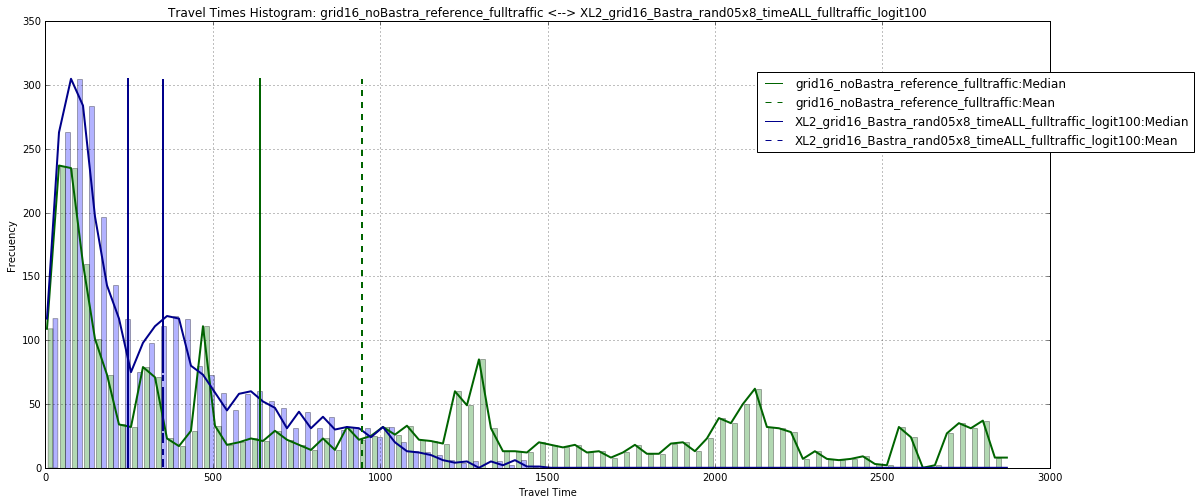

,,Stat,Units,Analysis,stat,pvalue
0,Travel Time,T-TEST,(t_stat)(p_value),"With confidence 5%, equal variances are differ...",stat=34.1306027481,p_val=4.08983614681e-232
1,Route Length,T-TEST,(t_stat)(p_value),We cannot assure with confidence of 5% that va...,stat=-0.141385592183,p_val=0.887570423127
2,Diff in Travel Time,Shapiro,,We cannot assure with confidence of 5% that va...,stat=-0.141385592183,p_val=0.887570423127
3,Travel Time Diff secs,Shapiro Normality,secs,With confidence 5% is not normal,,2.43382e-40
4,Travel Time Diff secs,mean,t.units,,593.366,
5,Travel Time Diff secs,median,t.units,,253,
6,Travel Time Diff secs,std.deviation,t.units,,781.049,
7,Travel Time Diff %,Shapiro Normality,%,With confidence 5% is not normal,,0
8,Travel Time Diff %,mean,%,,0.231258,
9,Travel Time Diff %,median,%,,0.394857,


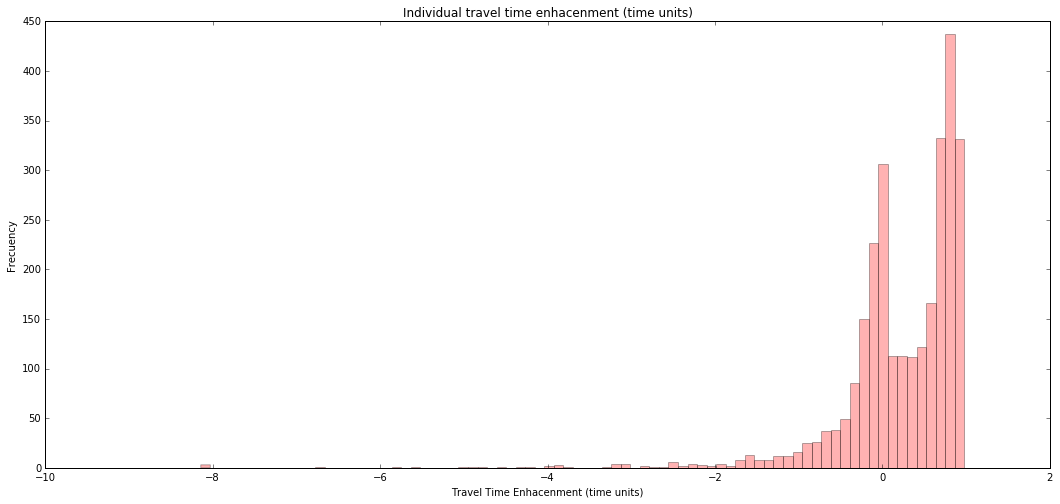

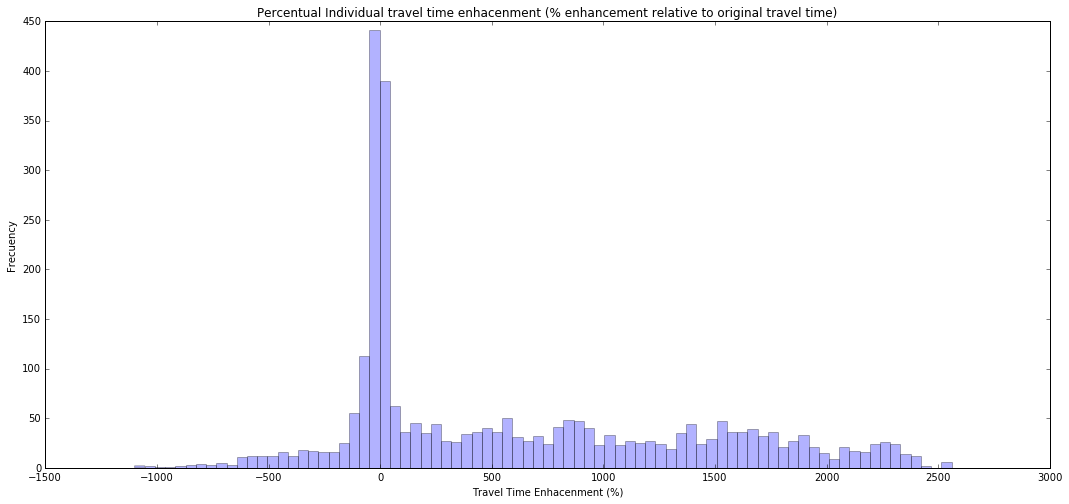

Saved file /tmp/mutraff-grid16_noBastra_reference_fulltraffic-XL2_grid16_Bastra_rand05x8_timeALL_fulltraffic_logit100.csv


In [62]:
compare_scenarios( BASTRA_PATH, label1, experiment1, label2, experiment2 )

# BACKUP